In [348]:
a,b = 1,100   # parameters for Rosenbrock function
f = lambda x,y: (a-x)**2+b*(y-x**2)**2
Df = lambda x,y: np.array([2*(x-a)-4*b*x*(y-x**2),
                           2*b*(y-x**2)])

x0,y0 = 1.2,1.2    # initial point for all methods

In [349]:
import numpy as np
from numpy.linalg import norm, solve, multi_dot
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

In [350]:
def PR_beta(Dfk,Dfk1, pk): #doesn't use pk, just including the parameter since other beta methods use pk
    return ((Dfk1-Dfk)@Dfk1) / (Dfk@Dfk)

In [351]:
def FR_beta(Dfk,Dfk1, pk): #doesn't use pk
    return (Dfk1@Dfk1) / (Dfk@Dfk)

In [352]:
def nonlinear_exact_line_search_CG(x0, y0, f, Df, beta, restart=False, restart_itr=2 , tol=1e-8, max_steps=10000):
    x,y = x0,y0
    path = [[x,y]]
    i=0 # iteration count
    dx = Df(x,y)          # current gradient
    pk = -dx
    while np.linalg.norm(dx)>tol and i<max_steps:    
        def subproblem1D(alpha):                  # exact line search
            return f(x + alpha*pk[0], y + alpha*pk[1])
        
        res = minimize_scalar(subproblem1D)
        alpha= res.x      
        xnew,ynew = x + alpha*pk[0], y + alpha*pk[1]
        
        dx1 = Df(xnew,ynew)      # Df_{k+1}
        bk = beta(dx,dx1,pk)  # beta_k
        if restart and i%restart_itr == 0:
            bk=0
        pk = -dx1 + bk*pk
        path.append([xnew,ynew])
        x,y = xnew,ynew
        dx = dx1
        i += 1
    return np.array(path), i, x, y

In [353]:
def plot_path(path, func, title, window=[0,3,0,3], numContours=50, skip=1):
    '''Plots path defined in (N,2) array "path" on a contour plot of "func" in window "window"'''
    plt.figure(figsize=(10,10))
    X = np.linspace(window[0],window[1],300)
    Y = np.linspace(window[2],window[3],300)
    Xmesh, Ymesh = np.meshgrid(X,Y)
    Z = func(Xmesh,Ymesh)
    CS = plt.contour(Xmesh, Ymesh, Z, numContours, cmap='jet')
    plt.clabel(CS,inline_spacing=0,fmt='%d')
    plt.axis(window)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)

    for i in range(path.shape[0]-1): # iterate through steps
        if i%skip==0:
            # only plot arrows every "skip" iterations
            plt.arrow(path[i,0],path[i,1],path[i+1,0]-path[i,0],path[i+1,1]-path[i,1],
                      color='k',length_includes_head=True)
    plt.show()

In [354]:
def approx_convergence_rate1(path):
    '''Given a path defined by an iteration and a known minimizer, approximates convergence rate'''
    p=np.log(np.linalg.norm(np.array(path[-1])-np.array(path[-2])
                           )/(np.linalg.norm(np.array(path[-2])-np.array(path[-3])))
            )/(np.log(np.linalg.norm(np.array(path[-2])-np.array(path[-3])
                                     )/(np.linalg.norm(np.array(path[-3])
                                                       -np.array(path[-4])))))
    return p

In [355]:
def approx_convergence_rate2(path, minimizer, numToAvg=10,showPlot=True):
    '''Given a path defined by an iteration and a known minimizer, approximates convergence rate'''
    path=list(path)
    path1=path[1:-1]
    path2=path[0:-2]
    path1=np.array(path1)
    path2=np.array(path2)
    err = np.linalg.norm(path1-path2,axis=1) # ||x_k-x*||=e_k
    
    # if converged in very few steps, return infinite order
    if len(err)<=3:
        return np.inf
    
    pp = np.zeros(len(err)-3)
    for i in range(len(err)-3):
        pp[i] = np.log(err[i+2]/err[i+1])/np.log(err[i+1]/err[i])
    
    if numToAvg>len(pp):
        # if not enough iterations to average, just average all
        p=np.mean(pp)
    else:
        # return mean of last few iterations
        p=np.mean(pp[-numToAvg:])
        
    # plot
    if showPlot:
        plt.plot(pp)
        plt.plot(pp*0+p)
        plt.xlabel('k')
        plt.ylabel('p')
        plt.title(f'p={p}')
        plt.show()
        
    return p

In [356]:
def approx_convergence_rate(path, minimizer, numToAvg=3, showPlot=True):
    '''Given a path defined by an iteration and a known minimizer, approximates convergence rate'''
    err = np.linalg.norm(path-np.array(minimizer),axis=1) # ||x_k-x*||=e_k
    
    # if converged in very few steps, return infinite order
    if len(err)<=3:
        return np.inf
    
    pp = np.zeros(len(err)-3)
    for i in range(len(err)-3):
        pp[i] = np.log(err[i+2]/err[i+1])/np.log(err[i+1]/err[i])
    
    if numToAvg>len(pp):
        # if not enough iterations to average, just average all
        p=np.mean(pp)
    else:
        # return mean of last few iterations
        p=np.mean(pp[-numToAvg:])
        
    # plot
    if showPlot:
        plt.plot(pp)
        plt.plot(pp*0+p)
        plt.xlabel('k')
        plt.ylabel('p')
        plt.title(f'p={p}')
        plt.show()
        
    return p

In [357]:
def linear_convergent_check(path,minimizer):
    con=(np.linalg.norm(path[-1]-minimizer))/(np.linalg.norm(path[-2]-minimizer))
    return con

In [358]:
def approx_convergence_rate3(path, minimizer):
    '''Given a path defined by an iteration and a known minimizer, approximates convergence rate'''
    p=np.log(np.linalg.norm(np.array(path[-1])-minimizer
                           )/(np.linalg.norm(np.array(path[-2])-minimizer))
            )/(np.log(np.linalg.norm(np.array(path[-2])-minimizer
    )/(np.linalg.norm(np.array(path[-3])-minimizer))))
    return p

## A with initial point (1.2,1.2), study convergence with no restart

In [389]:
x0,y0 = 1.2,1.2    # initial point for all methods

In [390]:
path_PR, i, x, y = nonlinear_exact_line_search_CG(x0, y0, f, Df, PR_beta, False)
print(f'After {i} iterations, approximate minimum is {f(x,y)} at {x,y}')

After 10 iterations, approximate minimum is 1.1088426099012847e-28 at (1.0000000000000095, 1.0000000000000195)


In [391]:
path_FR, i, x, y=nonlinear_exact_line_search_CG(x0, y0, f, Df, FR_beta, False)
print(f'After {i} iterations, approximate minimum is {f(x,y)} at {x,y}')

After 30 iterations, approximate minimum is 3.7186327915733286e-17 at (1.0000000060888288, 1.0000000122111974)


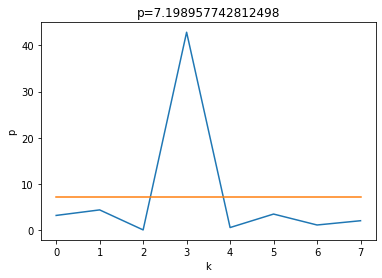

7.198957742812498

In [392]:
approx_convergence_rate(path_PR, [1,1], numToAvg=100,showPlot=True)

In [393]:
approx_convergence_rate1(path_PR)

2.039313748875837

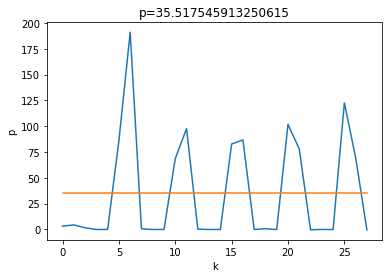

35.517545913250615

In [394]:
approx_convergence_rate(path_FR, (1,1), numToAvg=100,showPlot=True)

In [395]:
approx_convergence_rate1(path_FR)

1.8162934057305442

#### From above analysis, we can see that PR method is superlinear with 2.04 convergence rate, and FR method is also superlinear with 1.82 convergence rate, when norm of gradient is very low. If considering the all iterations, both mehods are convergent superlinear.

## With restart every 3 iterations

In [396]:
path_PR, i, x, y = nonlinear_exact_line_search_CG(x0, y0, f, Df, PR_beta, True,3)
print(f'After {i} iterations, approximate minimum is {f(x,y)} at {x,y}')

After 12 iterations, approximate minimum is 2.820299792639095e-20 at (1.0000000000018956, 0.9999999999869985)


In [397]:
path_FR, i, x, y = nonlinear_exact_line_search_CG(x0, y0, f, Df, FR_beta, True,3)
print(f'After {i} iterations, approximate minimum is {f(x,y)} at {x,y}')

After 10 iterations, approximate minimum is 6.296760414157414e-21 at (1.000000000079289, 1.0000000001588945)


In [398]:
approx_convergence_rate1(path_PR)

-0.9353759255910976

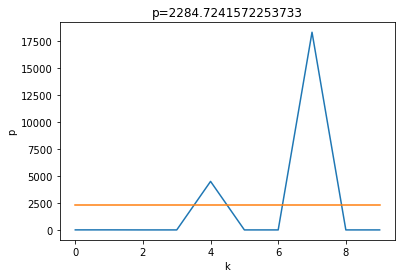

2284.7241572253733

In [399]:
approx_convergence_rate(path_PR, (1,1), numToAvg=100,showPlot=True)

In [400]:
approx_convergence_rate1(path_FR)

-1.6720674367636008

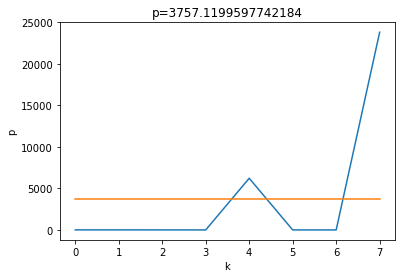

3757.1199597742184

In [401]:
approx_convergence_rate(path_FR, (1,1), numToAvg=100,showPlot=True)

#### From above analysis we can see that, when tol is very small, the usually the the convergence can be linear and superlinear. But, if considering the all the iterations, the whole process converge superlinear.

## With initial condition x0=-1.2, y0=1

In [406]:
x0=-1.2
y0=1

In [407]:
path_PR, i, x, y = nonlinear_exact_line_search_CG(x0, y0, f, Df, PR_beta, False,3)
print(f'After {i} iterations, approximate minimum is {f(x,y)} at {x,y}')

After 18 iterations, approximate minimum is 4.6340944995991903e-20 at (0.999999999954214, 0.9999999999294623)


In [408]:
path_FR, i, x, y = nonlinear_exact_line_search_CG(x0, y0, f, Df, FR_beta, False,3)
print(f'After {i} iterations, approximate minimum is {f(x,y)} at {x,y}')

After 217 iterations, approximate minimum is 1.7028073158123337e-17 at (1.0000000041264765, 1.0000000082513254)


In [409]:
approx_convergence_rate1(path_PR)

0.30703079300148184

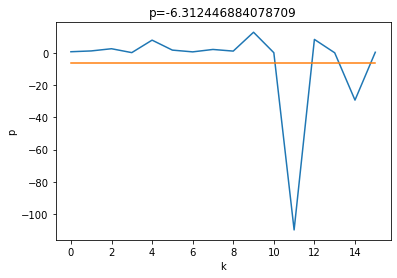

-6.312446884078709

In [410]:
approx_convergence_rate(path_PR, (1,1), numToAvg=100,showPlot=True)

In [411]:
approx_convergence_rate1(path_FR)

0.6833668354302425

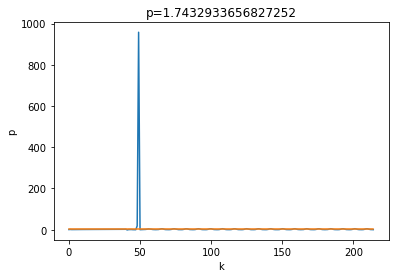

1.7432933656827252

In [412]:
approx_convergence_rate(path_FR, (1,1), numToAvg=100,showPlot=True)

#### If consider the norm of gradient very slow, both method convergent sublinear. If consider the whole process, the FR method converges superlinear, but PR isn't since one extreme diverge iteration. 

## with restart for every 3 iterations.

In [413]:
path_PR, i, x, y = nonlinear_exact_line_search_CG(x0, y0, f, Df, PR_beta, True,3)
print(f'After {i} iterations, approximate minimum is {f(x,y)} at {x,y}')

After 27 iterations, approximate minimum is 6.113486633150115e-25 at (0.9999999999999374, 0.9999999999999527)


In [414]:
path_FR, i, x, y = nonlinear_exact_line_search_CG(x0, y0, f, Df, FR_beta, True,3)
print(f'After {i} iterations, approximate minimum is {f(x,y)} at {x,y}')

After 19 iterations, approximate minimum is 3.2868744030716063e-17 at (1.0000000057258882, 1.0000000114805772)


In [415]:
approx_convergence_rate1(path_PR)

-0.8560935802301486

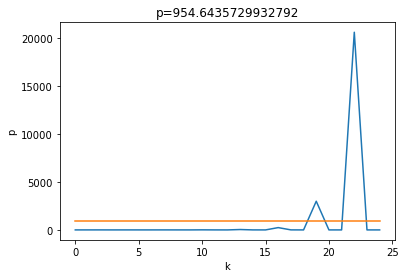

954.6435729932792

In [419]:
approx_convergence_rate(path_PR, (1,1), numToAvg=100,showPlot=True)

In [420]:
approx_convergence_rate1(path_FR)

-46.827373803631566

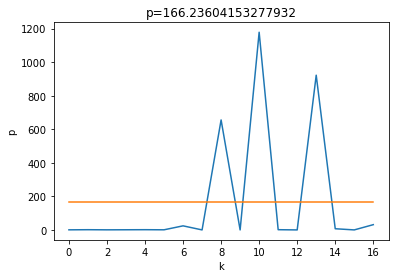

166.23604153277932

In [421]:
approx_convergence_rate(path_FR, (1,1), numToAvg=100,showPlot=True)

#### If consider the whole process , both method are super-linear converges. If study the small norm of gradient condition, they might not converge at all.